In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import pairplot
from dsn.util.dsn_util import get_system_from_template, grid_search, abc_sample
from scipy.stats import multivariate_normal as mvn
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [6]:
sysname = 'V1Circuit'
behavior_type = "rates"
param_dict = {'behavior_type':behavior_type, 'fac':1.0, 's':10}
system = get_system_from_template(sysname, param_dict)


Z = tf.placeholder(tf.float64, (1,None,system.D))
T_x = system.compute_suff_stats(Z)

"""r_t_tf = system.simulate(Z)
with tf.Session() as sess:
    r_t = sess.run(r_t_tf, {Z:np.ones((1,1,4))})
colors = ['k', 'b', 'r', 'g']
t = np.arange(r_t.shape[0])
plt.figure()
for i in range(system.D):
    plt.plot(t, r_t[:,0,0,i,0], colors[i])
plt.show()
print(r_t[-1,0,0,:,0] < 0.05)"""


n_abc = 1000000
inds = np.array([0,1,2,3])
Z_abc = abc_sample(system, n_abc, sigma=0.1, inds=inds)
n_accepted = Z_abc.shape[0]
print('%d accepted, %.4f %%' % (n_accepted, 100* (n_accepted/n_abc)))

with tf.Session() as sess:
    _T_x_abc = sess.run(T_x, {Z:np.expand_dims(Z_abc, 0)})

d = np.sqrt(np.sum(np.square(_T_x_abc[0,:,inds].T - np.expand_dims(system.mu[inds], 0)), axis=1))

a, b = system.density_network_bounds

mu (8,) [0.79455573 0.81323765 0.87849146 1.09549525 0.79455573 0.81323765
 0.87849146 1.09549525]
56 accepted, 0.0056 %


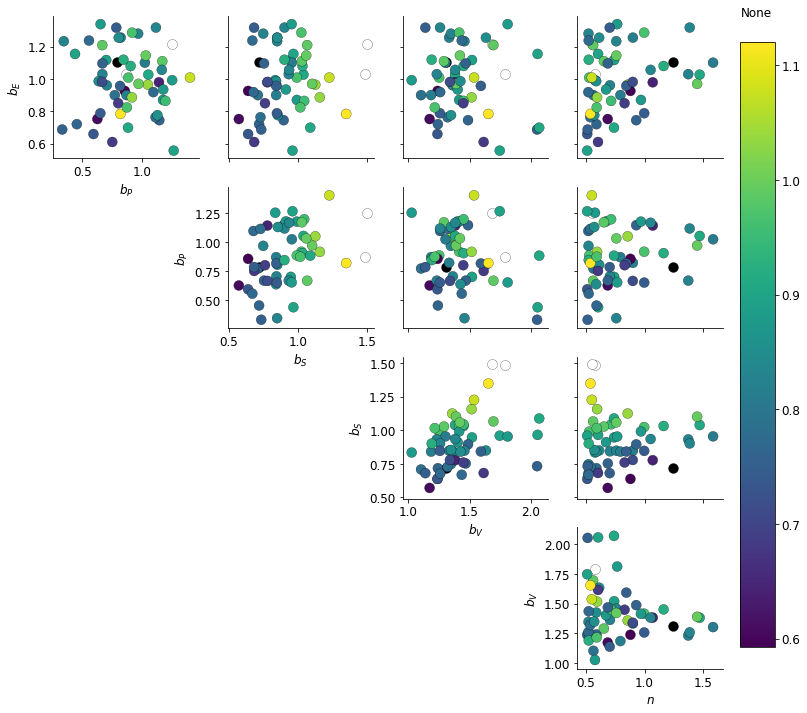

In [7]:
n_plot = 500
fig = pairplot(Z_abc[:n_plot,:], range(5), system.z_labels, c=_T_x_abc[0,:,2])

IndexError: index 8 is out of bounds for axis 1 with size 8

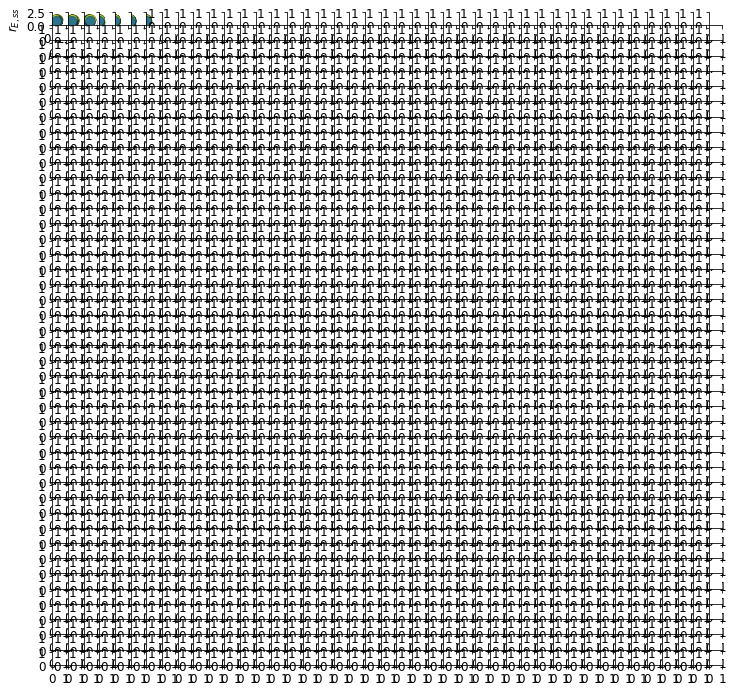

In [9]:
fig, axs = pairplot(_T_x_abc[0,:n_plot,:], range(44), system.T_x_labels,
                    xlims=[0,2.5], ylims=[0,2.5],
                    c=d[:n_plot])
for i in range(0,3):
    for j in range(i,3):
        axs[i,j].plot([system.mu[j+1]], [system.mu[i]], 'c*', markersize=20)

In [22]:
W_tf, b_tf, h_FF_tf, h_LAT_tf, h_RUN_tf, tau_tf, n_tf, s_0_tf, a_tf, c_50_tf = system.filter_Z(Z)
r_t_tf = system.simulate(Z)
with tf.Session() as sess:
    W, b, r_t = sess.run([W_tf, b_tf, r_t_tf], {Z:np.zeros((1,1,system.D))})
W = W[0,0]
b = b[0,0]
r_ss = r_t[-1,0,0]
print(W.shape)
print(b.shape)
print(r_ss.shape)

(4, 4)
(4, 1)
(4, 1)


In [22]:
def calculate_M(W, b, r_ss):
    F = 2*np.diag(np.sqrt(r_ss[:,0]))
    M_inv = np.linalg.inv(F) - W
    M = np.linalg.inv(M_inv)
    return M, M_inv


M, M_inv = calculate_M(W, b, r_ss)
dhdr = M

In [23]:
print('dh/dr')
print(dhdr)

dh/dr
[[ 7.86986325e-01 -1.56034126e-01 -6.07412151e-05  6.15371645e-03]
 [ 4.47439928e-01 -1.65249751e-02 -4.12709845e-05  4.18117971e-03]
 [-3.52946165e-03  9.69879391e-04  8.69485618e-06 -8.80879308e-04]
 [ 2.42654748e+01 -6.64121978e+00 -1.87460362e-03  5.97142988e+00]]


In [18]:
print(mu_init)
print(sigma_init)

[ 1.09171106  0.36959603 -0.00903438 -0.04601663]
[[ 1.59392385e+00  1.12963141e+00  2.49342300e+00 -2.38219325e-03]
 [ 1.12963141e+00  7.70481803e+00 -8.45376885e-03  1.26461689e-01]
 [ 2.49342300e+00 -8.45376885e-03  7.92629886e+00 -2.54645412e-01]
 [-2.38219325e-03  1.26461689e-01 -2.54645412e-01  7.94793778e+00]]


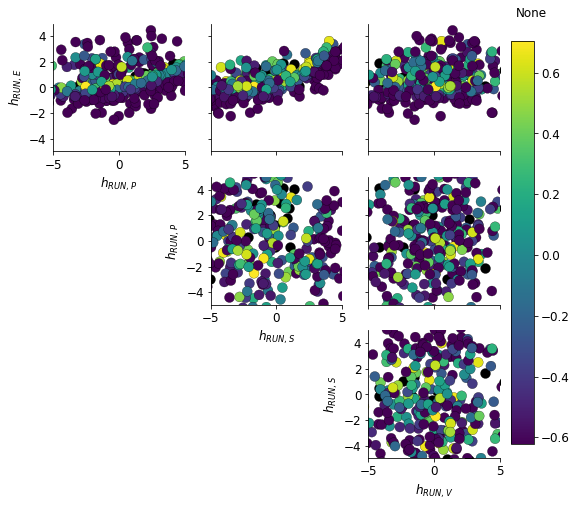

In [19]:
inds = _T_x_init[0,:,0] < 1
fig = pairplot(Z_init[inds,:], range(4), system.z_labels, c=_T_x_init[0,inds,0],
               figsize=(8,8), xlims=[a[0], b[0]], ylims=[a[0], b[0]])